In [ ]:
!pip install shap
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import shap
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
!pip install umap-learn
import umap

In [ ]:
data = pd.read_csv('Customers.csv')
data

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6
...,...,...,...,...,...,...,...,...
1995,1996,Female,71,184387,40,Artist,8,7
1996,1997,Female,91,73158,32,Doctor,7,7
1997,1998,Male,87,90961,14,Healthcare,9,2
1998,1999,Male,77,182109,4,Executive,7,2


•	CustomerID — ID клиента;

•	Gender — пол;

•	Age возраст;

•	Annual Income ($) — годовой доход;

•	Spending Score (1-100) — оценка расходов;

•	Profession — профессия;

•	Work Experience — опыт работы;

•	Family size — размер семьи.

In [ ]:
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

In [ ]:
y = data['Spending Score (1-100)']
X = data.drop(columns=['CustomerID', 'Spending Score (1-100)', 'Profession'])

In [ ]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
# Оценка значимости признаков на основе p-value
X_with_const = sm.add_constant(X)
model_sm = sm.OLS(y, X_with_const).fit()
p_values = model_sm.pvalues[1:]
significant_features = X.columns[p_values < 0.1]
print(significant_features)

Index(['Age'], dtype='object')


In [ ]:
# Оценка значимости признаков на основе весов
weights = model.coef_
significant_features = X.columns[weights != 0]
print(significant_features)

Index(['Gender', 'Age', 'Annual Income ($)', 'Work Experience', 'Family Size'], dtype='object')


In [ ]:
lasso_model = Lasso()
lasso_model.fit(X, y)

Lasso()

In [ ]:
significant_features = X.columns[lasso_model.coef_ != 0]
print(significant_features)

Index(['Age', 'Annual Income ($)', 'Work Experience'], dtype='object')


In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

RandomForestRegressor()

In [ ]:
# Вывод значимости признаков на основе feature_importances_
feature_importances_rf = rf_model.feature_importances_
print(feature_importances_rf)

[0.04079297 0.28441104 0.39744183 0.14786177 0.12949238]


In [ ]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X, y)

GradientBoostingRegressor()

In [ ]:
feature_importances_gb = gb_model.feature_importances_
print(feature_importances_gb)

[0.03055272 0.28005662 0.56108592 0.07436536 0.05393938]


In [ ]:
# Оценка значимости признаков с помощью SHAP-значений
explainer = shap.Explainer(gb_model)
shap_values = explainer.shap_values(X)
feature_importance_shap = np.abs(shap_values).mean(axis=0)
print(feature_importance_shap)

[0.23247474 1.96076286 2.53750666 0.95036179 0.7024045 ]


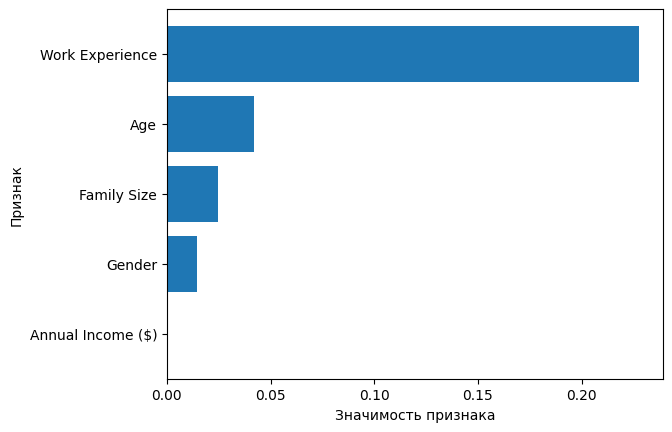

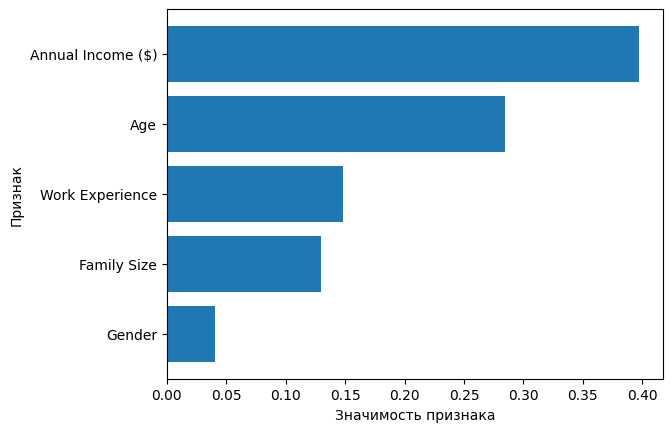

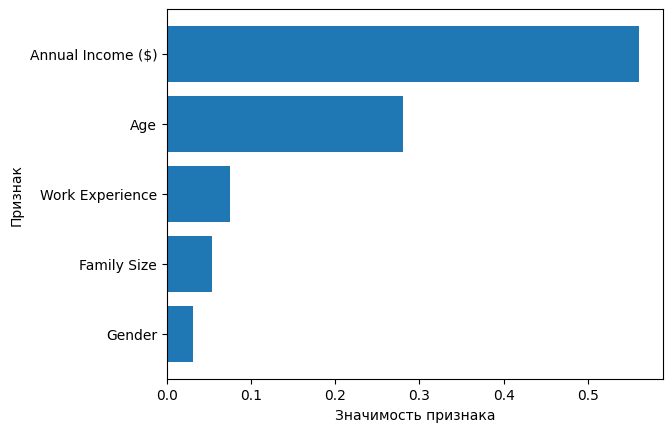

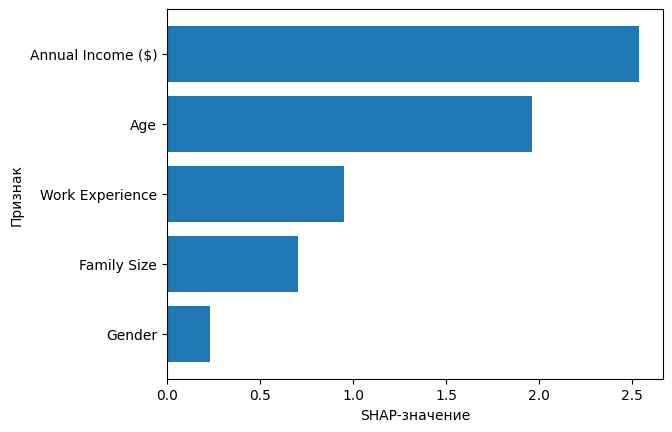

In [ ]:
import matplotlib.pyplot as plt

# Отсортированная значимость признаков для линейной модели
sorted_weights = np.sort(np.abs(weights))
sorted_features = X.columns[np.argsort(np.abs(weights))]
plt.barh(sorted_features, sorted_weights)
plt.xlabel("Значимость признака")
plt.ylabel("Признак")
plt.show()

# Отсортированная значимость признаков для случайного леса
sorted_importances_rf = np.sort(feature_importances_rf)
sorted_features_rf = X.columns[np.argsort(feature_importances_rf)]
plt.barh(sorted_features_rf, sorted_importances_rf)
plt.xlabel("Значимость признака")
plt.ylabel("Признак")
plt.show()

# Отсортированная значимость признаков для градиентного бустинга
sorted_importances_gb = np.sort(feature_importances_gb)
sorted_features_gb = X.columns[np.argsort(feature_importances_gb)]
plt.barh(sorted_features_gb, sorted_importances_gb)
plt.xlabel("Значимость признака")
plt.ylabel("Признак")
plt.show()

# Отсортированная значимость признаков на основе SHAP-значений
sorted_importance_shap = np.sort(feature_importance_shap)
sorted_features_shap = X.columns[np.argsort(feature_importance_shap)]
plt.barh(sorted_features_shap, sorted_importance_shap)
plt.xlabel("SHAP-значение")
plt.ylabel("Признак")
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

# Оценка качества модели на всех признаках
scores_all_features = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
print(scores_all_features)

# Определение самых значимых признаков
top_features = sorted_features[:5]
print(top_features)

# Оценка качества модели на самых значимых признаках
scores_top_features = cross_val_score(model, X[top_features], y, cv=5, scoring="neg_mean_squared_error")
print(scores_top_features)


[-770.71604367 -840.3830553  -753.31479897 -803.9642162  -740.32607264]
Index(['Annual Income ($)', 'Gender', 'Family Size', 'Age', 'Work Experience'], dtype='object')
[-770.71604367 -840.3830553  -753.31479897 -803.9642162  -740.32607264]


In [ ]:
# Применение алгоритма PCA
pca = PCA(n_components=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[9.99999594e-01 3.97017212e-07 7.26203515e-09 1.87934107e-09
 1.16718016e-10]


In [ ]:
import umap
from sklearn.preprocessing import StandardScaler
u = umap.UMAP()
scaled_X = StandardScaler().fit_transform(X)
umap_features = u.fit_transform(scaled_X)

In [ ]:
import plotly.express as px

fig = px.scatter(umap_features, x=umap_features[:,0], y=umap_features[:,1])
fig.update_layout(title='UMAP')
fig.show()